In [1]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

## Linear Regression
First generate some data. Here we have a case of a linear regression with constant scatter:

$$
y_i \sim m \cdot x_i + c + \mathcal{N}(0,E)
$$

Where $x\sim U(0,10)$ and $(m,c,E) = (2,3.5,1.35)$, and we have $32$ observations.

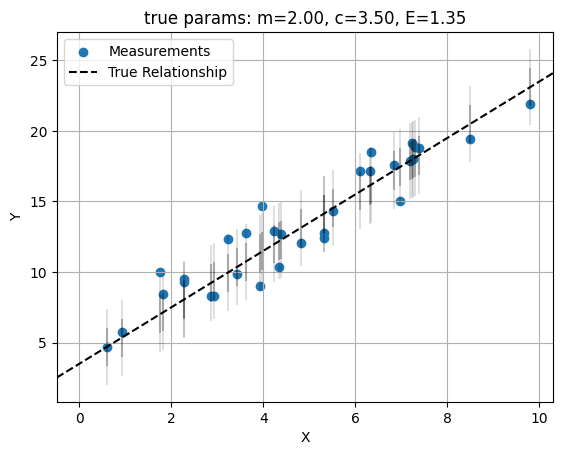

In [2]:
# Model 'truth' parameters  
m_true = 2  
c_true = 3.5  
E_true = 1.35
  
#----------------------------  
# Data generation  
ebar, escatter = 1.5, 10 # Average & spread of error bar  
  
np.random.seed(123) # Fix the random seed so results are consistent across different examples  
X = np.random.rand(32) * 10  
E = np.random.poisson(lam=escatter, size=1) / escatter * ebar  
E = float(E)
Y = m_true*X + c_true + E*np.random.normal(size=len(X)) # Linear rel /w random noise based on 'E'  
  
#--------------  
# Plotting  
plt.figure()  
plt.scatter(X,Y,label='Measurements')  
plt.errorbar(X,m_true*X+c_true,E,fmt='none', capsize=0, c='k', alpha=0.25)  
plt.errorbar(X,m_true*X+c_true,E*2,fmt='none', capsize=0, c='k', alpha=0.125)  
plt.axline( [0,c_true], slope=m_true, c='k', ls='--', label='True Relationship')  
plt.legend(loc='best')  
plt.xlabel("X"), plt.ylabel("Y")  

plt.title("true params: m=%.2f, c=%.2f, E=%.2f" %(m_true,c_true,E))
plt.grid()  
plt.show()  

## Analytic Example

In this example we know the likelihood function analytically. Ignoring matters of normalization, it obeys:

$$
\mathcal{L}(x\vert\theta) \propto \prod_i \frac{1}{E} \exp \left(\frac{-1}{2} \left( \frac{m\cdot x_i  + c - y_i}{E} \right)^2 \right)
$$

Defining as a function:

In [3]:
def f_LL_exact(m,c,E,X,Y):
    Y_pred = X*m + c
    out = -1/2 * (Y-Y_pred)**2 / E**2 - np.log(E)
    out = out.sum()
    return(out)

And then evaluating this on a grid...

In [4]:
Mgrid, Cgrid, Egrid = np.linspace(1.2,3,64+1, endpoint=False)[1:], np.linspace(0,6,64+1, endpoint=False)[1:], np.linspace(0,5,64+1, endpoint=False)[1:]
Mgrid, Cgrid, Egrid = np.meshgrid(Mgrid, Cgrid, Egrid)
Mgrid, Cgrid, Egrid = Mgrid.flatten(), Cgrid.flatten(), Egrid.flatten()

LL_exact = np.array([f_LL_exact(m, c, e, X, Y) for m,c,e in zip(Mgrid, Cgrid, Egrid)])

...and passing to `chainconsumer` to see observe the ground truth:

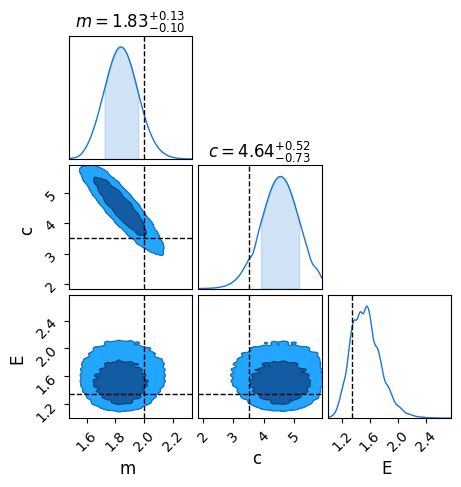

In [5]:
C = ChainConsumer()
truth = {'m': m_true, 'c': c_true, 'E': E}
C.add_chain({'m': Mgrid, 'c':Cgrid, 'E': Egrid}, weights=np.exp((LL_exact-LL_exact.max())), name="Exact Result")
C.plotter.plot(truth = truth)
plt.show()

## Attacking this with SNPE
Now on to `sbi`, specifically the **Simulated Neural Posterior Estimation**. This simulates a large set of data and then trains a neural network to learn what the posterior distribution looks like for some data set. To begin, set up a prior distribution for `sbi` and turn the numpy-like data `X,Y` into `torch`-friendly tensors:

In [6]:
prior = utils.BoxUniform(low=torch.Tensor([-5, -10, 0]),
                        high=torch.Tensor([5, 10, 5]))

Xtorch, Ytorch = torch.from_numpy(X), torch.from_numpy(Y)

Then create a generative model. I'm training this one to take the entire vectors `X` and `Y` as its input and output. We generate simulations and train the neural network to learn what posteriors should look like:

In [7]:
def simulator_SNPE(parameter_set: 'm, c, E'):
    m, c, _E = parameter_set
    out = m*Xtorch + c + _E * torch.randn(Xtorch.shape)
    return out

posterior_SNPE = infer(simulator_SNPE, prior, method="SNPE", num_simulations=10_000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 139 epochs.

Now we can draw MCMC-like samples for our observed data, which lives in `Ytorch`:

In [8]:
samples_SNPE = posterior_SNPE.sample((50_000,), x=Ytorch)

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Now make a torch-friendly grid of sites and fire them in 

With samples like this, we can extract them into a `chainconsumer` friendly format. `torch` tensors dont play nice with `chainconsumer`, unfortunately, so we need to transform them back into `numpy` arrays with a somewhat obtuse command:

In [9]:
samples_forcc = {'m':samples_SNPE[:,0].detach().cpu().numpy(), 
                 'c':samples_SNPE[:,1].detach().cpu().numpy(), 
                 'E':samples_SNPE[:,2].detach().cpu().numpy()
                }

With this in hand we can compare to the ground truth. The neural net has done a good job of learning what the gradient and offset look like, but has had a little trouble with estimating the scatter. With a longer training run / more simulations this would eventually converge.

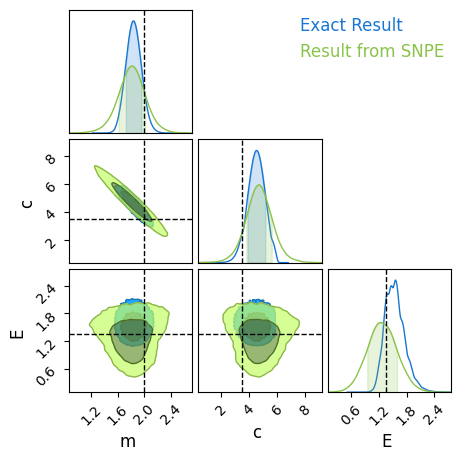

In [10]:
C.add_chain(samples_forcc, name = "Result from SNPE")
C.plotter.plot(truth = truth)
plt.show()

## SNLE

Unlike SNPE, SNLE limits its scope to using neural nets to learn a shape for the likelihood function, filling in that specific gap in cases where we don't have a closed form mathematical expression. In that spirit, I'm going to set the generative model up to only simulate _one_ data point at a time, i.e.:

$$
\mathcal{L}(\vec{x} ,\vec{y} \vert x,m,c,E) = \exp \left( \sum_i f(x_i,y_i\vert m,c,E) \right)
$$

Where $f(x , y \vert m,c,E)$ is some function learned by a neural net:

In [11]:
def simulator_SNLE(parameter_set: 'm, c, E'):
    m, c, _E = parameter_set
    _X = torch.rand(1)*10
    _Y = m*_X + c + _E * torch.randn(1)
    out = torch.cat([_X, _Y])
    return out

posterior_SNLE = infer(simulator_SNLE, prior, method="SNLE", num_simulations=1_000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 83 epochs.

Now we can evaluate this function over the same grid as before, after doing a little rearranging of the data:

In [12]:
observation = [[x,y] for x,y in zip(X,Y)]
sites = [[float(x), float(y), float(e)] for x, y, e in zip(Mgrid,Cgrid, Egrid)]
LL = sum([posterior_SNLE.log_prob( sites, x=observation[i]) for i in range(len(observation))])

/home/hughmc/anaconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/inference/posteriors/mcmc_posterior.py:174: UserWarning: `.log_prob()` is deprecated for methods that can only evaluate the
            log-probability up to a normalizing constant. Use `.potential()` instead.
  log-probability up to a normalizing constant. Use `.potential()` instead."""
/home/hughmc/anaconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/inference/posteriors/mcmc_posterior.py:176: UserWarning: The log-probability is unnormalized!
  warn("The log-probability is unnormalized!")


Comparing, we see that this hasn't done the best job of converging, even with $10,000$ simulated datapoints.

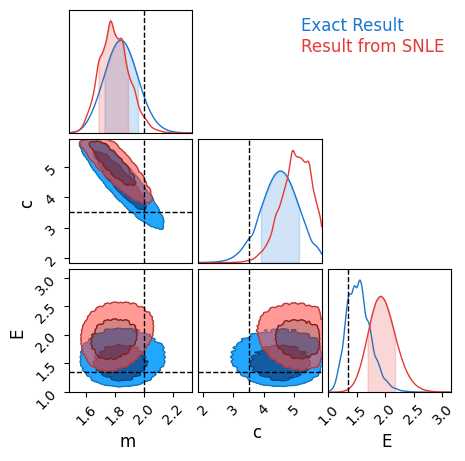

In [13]:
C.add_chain({'m': Mgrid, 'c':Cgrid, 'E': Egrid}, weights=np.exp((LL-LL.max())).detach().cpu().numpy(), name = "Result from SNLE")
C.plotter.plot(truth = truth, chains = ["Exact Result", "Result from SNLE"])
plt.show()